In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import SwinForImageClassification
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np

In [2]:
dataset_dir = '/kaggle/input/brainstroke2class/dataset'
torch.manual_seed(42)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [3]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [4]:
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=1,  # Your number of output classes
    ignore_mismatched_sizes=True  # This avoids the classifier output class mismatch error
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([1, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs!


DataParallel(
  (module): SwinForImageClassification(
    (swin): SwinModel(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0): SwinLayer(
                (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=128, out_features=128, bias=True)
                    (key): Linear(in_features=128, out_features=128, bias=True)
                    (value): Linear(in_features=128, out_features=128, bias=True)
                    (dropout): Dropout(p=0.0, inplace=

In [5]:
print(model)

DataParallel(
  (module): SwinForImageClassification(
    (swin): SwinModel(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0): SwinLayer(
                (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=128, out_features=128, bias=True)
                    (key): Linear(in_features=128, out_features=128, bias=True)
                    (value): Linear(in_features=128, out_features=128, bias=True)
                    (dropout): Dropout(p=0.0, inplace=

In [6]:
for param in model.module.swin.parameters():
    param.requires_grad = False
for param in model.module.classifier.parameters():
    param.requires_grad = True

In [7]:
optimizer = optim.Adam([
    {'params': model.module.swin.parameters(), 'lr': 5e-5},  
    {'params': model.module.classifier.parameters(), 'lr': 1e-3} 
])
criterion = nn.BCEWithLogitsLoss()

In [8]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100
# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate through training data
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.logits.squeeze(), labels.float())

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track running loss
        running_train_loss += loss.item()

        # Track accuracy
        predicted = (torch.sigmoid(outputs.logits.squeeze()) > 0.5).long()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss and accuracy for this epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.logits.squeeze(), labels.float())

            running_val_loss += loss.item()

            # Track validation accuracy
            predicted = (torch.sigmoid(outputs.logits.squeeze()) > 0.5).long()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

 # Average validation loss and accuracy for this epoch
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print epoch stats
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/100], Train Loss: 0.4903, Train Accuracy: 77.01%, Validation Loss: 0.4277, Validation Accuracy: 82.78%
Epoch [2/100], Train Loss: 0.4058, Train Accuracy: 81.99%, Validation Loss: 0.4271, Validation Accuracy: 80.30%
Epoch [3/100], Train Loss: 0.3817, Train Accuracy: 83.46%, Validation Loss: 0.3791, Validation Accuracy: 84.51%
Epoch [4/100], Train Loss: 0.3630, Train Accuracy: 84.51%, Validation Loss: 0.3800, Validation Accuracy: 84.14%
Epoch [5/100], Train Loss: 0.3442, Train Accuracy: 85.39%, Validation Loss: 0.3866, Validation Accuracy: 82.78%
Epoch [6/100], Train Loss: 0.3359, Train Accuracy: 85.39%, Validation Loss: 0.3559, Validation Accuracy: 85.79%
Epoch [7/100], Train Loss: 0.3307, Train Accuracy: 85.81%, Validation Loss: 0.3449, Validation Accuracy: 86.02%
Epoch [8/100], Train Loss: 0.3224, Train Accuracy: 86.45%, Validation Loss: 0.3604, Validation Accuracy: 84.21%
Epoch [9/100], Train Loss: 0.3171, Train Accuracy: 86.50%, Validation Loss: 0.3430, Validation Accuracy:

In [9]:
torch.save(model.state_dict(), 'swin5e-5model.pth') 

In [10]:
# Function to Evaluate Model on Any Dataset (Validation or Test)
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred_prob = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs.logits)
            
            y_true.extend(labels.cpu().numpy())
            y_pred_prob.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob >= 0.5).astype(int)
 # Compute Metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  
    auc_score = roc_auc_score(y_true, y_pred_prob)

    # Print Results
    print(f"\nConfusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"AUC Score: {auc_score:.4f}")

    return y_true, y_pred_prob, cm, auc_score, accuracy, precision, recall, specificity

# Evaluate on Validation Set
print("\n Evaluating on Validation Set:")
evaluation_list = evaluate_model(model, val_dataloader)


 Evaluating on Validation Set:

Confusion Matrix:
[[823  59]
 [106 342]]
Accuracy: 0.8759
Precision: 0.8529
Recall (Sensitivity): 0.7634
Specificity: 0.9331
AUC Score: 0.9379


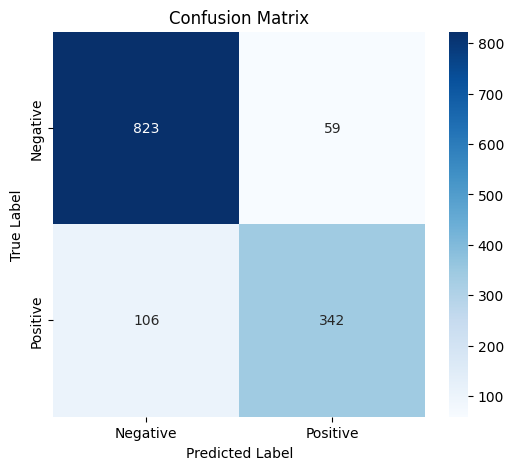

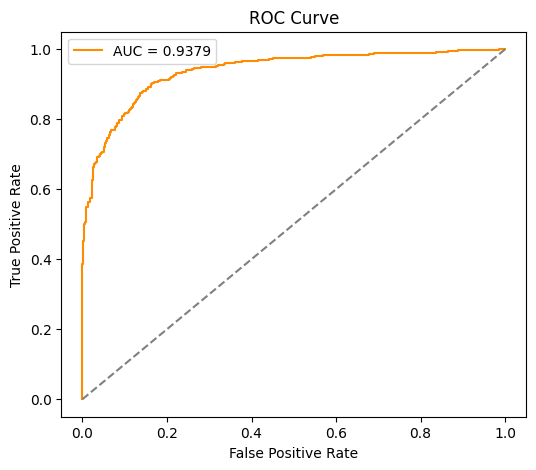

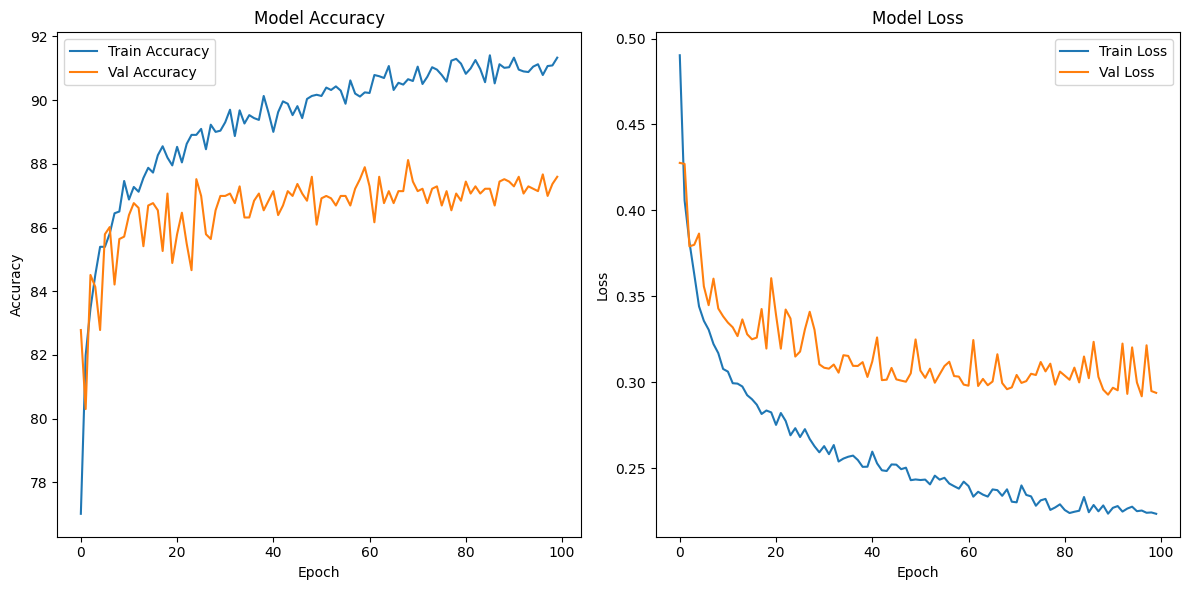

In [11]:
# Plot Confusion Matrix
y_true, y_pred_prob, cm, auc_score = evaluation_list[:4]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Train_Val accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Train_Val loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
